**Most of this notebook is ported from the original repository with the aim of making a minimal finetuning implementation.**

# Minimal Flax Implementation of of MLP-Mixer from "MLP-Mixer: An all-MLP Architecture for Vision"

![](https://github.com/SauravMaheshkar/MLP-Mixer/blob/main/assets/MLPMixer%20Banner.png?raw=true)

The strong performance of recent vision architectures is often attributed to Attention or Convolutions. But Multi Layer Perceptrons have always been better at capturing long-range dependencies and positional patterns, but admittedly fall behind when it comes to learning local features, which is where CNNs shine. An interesting new perspective of viewing convolutions as a "**sparse FC with shared parameters**" was proposed in [**Ding, et al**](https://arxiv.org/pdf/2105.01883.pdf). This perspective opens up a new way of looking at architectures. In this report we'll look at one such [**paper**](https://arxiv.org/pdf/2105.01601v1.pdf) which explores the idea of using convolutions with an extremely small kernel size of (1,1) essentially turning convolutions into standard matrix multiplications applied independently to each spatial location.  This modification alone doesn't allow for the aggregation of spatial information. To compensate for this the authors proposed dense matrix multiplications that are applied to every feature across all spatial locations.

This repository includes a minimal implementation of MLP-Mixer written in [Flax](https://github.com/google/flax). Most of the codebase is ported from the [original implementation](https://github.com/google-research/vision_transformer).

# Basic Setup 🏗

## Install Library

In [ ]:
%%capture
!pip install --upgrade git+https://github.com/SauravMaheshkar/MLP-Mixer.git

## Setup Jax on TPU

In [ ]:
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

## Import Libraries

In [ ]:
import os
import jax
import flax
import tqdm
import numpy as np
from matplotlib import pyplot as plt
from mlpmixer_flax import checkpoint
from mlpmixer_flax.models import MlpMixer
from mlpmixer_flax import train_utils, train
from mlpmixer_flax.config import mixer_b16_config

## Download Official Weights

In [ ]:
model_name = 'Mixer-B_16'  

if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

assert os.path.exists(f'{model_name}.npz')

Copying gs://mixer_models/imagenet21k/Mixer-B_16.npz...
| [1 files][289.6 MiB/289.6 MiB]                                                
Operation completed over 1 objects/289.6 MiB.                                    


## Utility Functions

In [ ]:
labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

# Model and DataLoader

## Basic Configuration

In [ ]:
from mlpmixer_flax.config import configuration
from mlpmixer_flax.dataloader import get_dataset_info
from mlpmixer_flax import dataloader


dataset = 'cifar10'
batch_size = 512
config = configuration
num_classes = get_dataset_info(dataset, "train")["num_classes"]
config.update(dataset = dataset)
config.update(batch = batch_size)
config.update({"pp": {"crop": 224}})

## Install Dataset

In [ ]:
%%capture
ds_train = dataloader.get_data_from_tfds(config=config, mode='train')
ds_test = dataloader.get_data_from_tfds(config=config, mode='test')

## Inspect Dataset 👀

In [ ]:
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 8
base_lr = 0.03

In [ ]:
del config 

batch = next(iter(ds_test.as_numpy_iterator()))
batch['image'].shape

(8, 64, 224, 224, 3)

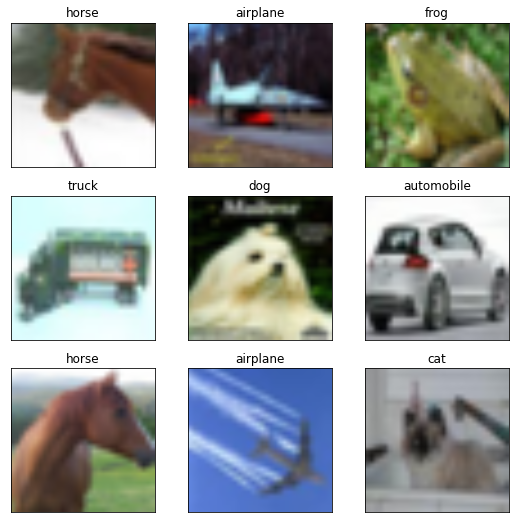

In [ ]:
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

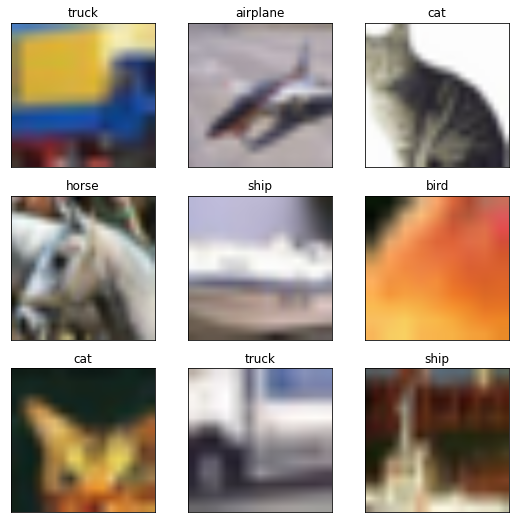

In [ ]:
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

## Build the Model 🤙

In [ ]:
model = MlpMixer(num_classes=num_classes, **mixer_b16_config)

variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    batch['image'][0, :1],
    train=False,
), backend='tpu')()

In [ ]:
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=mixer_b16_config,
)

In [ ]:
params_repl = flax.jax_utils.replicate(params)
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 8
base_lr = 0.03

lr_fn = train_utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
opt = train_utils.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

# Training and Evaluation

In [ ]:
losses = []
lrs = []

for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

In [ ]:
plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [ ]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [ ]:
get_accuracy(opt_repl.target)

100%|██████████| 19/19 [01:03<00:00,  3.37s/it]


DeviceArray(0.9661801, dtype=float32)